# DATA606 Week 8 & 9 & 10 - Modeling
Team 2 UMBC Spring 2024

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### File imports

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config

import xgboost as xgb
import scipy.stats as stats

#visuals
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams


#model selection tools
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import KFold


#models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

from datetime import datetime

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def dateInRange(date,startDate,endDate):
  return startDate <= date <= endDate

def datetoCongress(date):
  if dateInRange(date, datetime(2023,1,3),datetime(2025,1,2)):
    return 118
  elif dateInRange(date, datetime(2021,1,3),datetime(2023,1,2)):
    return 117
  elif dateInRange(date, datetime(2019,1,3),datetime(2021,1,2)):
    return 116
  elif dateInRange(date, datetime(2017,1,3),datetime(2021,1,2)):
    return 115
  else:
    return 114

## Data Transformation

### Senator Approval Ratings and Demographic Data

In [1]:
#df = pd.read_csv('/content/merged_votingpattern',parse_dates=['birthday','start_date','end_date'])
url1 = 'https://raw.githubusercontent.com/Ecross7/approvalRatings/main/Final_dataset3.csv'
url2 = 'https://raw.githubusercontent.com/Ecross7/approvalRatings/main/final4.csv'

In [4]:
df = pd.read_csv(url2,parse_dates=['birthday','start_date','end_date'])

In [5]:
df = df.rename(columns={'Emotion (Majority)': 'emotion_majority', 'Race (Majority)': 'race_majority', 'Valence (Mean)': 'valence_mean'})

In [6]:
df.columns

Index(['full_name', 'bioguide_id', 'govtrack_id', 'pct', 'birthday', 'gender',
       'election_date', 'party', 'senate_class', 'stage', 'cycle',
       'start_date', 'end_date', 'congressional', 'bills-introduced',
       'bills-with-companion', 'cosponsored', 'cosponsors', 'ideology',
       'leadership', 'missed-votes', 'Emotion', 'Norm_valence', 'Race', 'Val1',
       'Val2', 'Val3', 'Val_mean', 'Weight_val', 'Weighted_val_mean', 'age',
       'serving_age', 'emotion_majority'],
      dtype='object')

In [ ]:
df.dtypes

full_name                       object
bioguide_id                     object
govtrack_id                      int64
pct                            float64
birthday                datetime64[ns]
gender                          object
election_date                   object
party                           object
senate_class                   float64
stage                           object
cycle                            int64
start_date              datetime64[ns]
end_date                datetime64[ns]
congressional                    int64
bills-introduced               float64
bills-with-companion           float64
cosponsored                    float64
cosponsors                     float64
ideology                       float64
leadership                     float64
missed-votes                   float64
dtype: object

In [ ]:
#df['congressional'] = df['start_date'].apply(lambda x: datetoCongress(x))

In [7]:
df[['Emotion','emotion_majority']]

Emotion emotion_majority
0          sad            happy
1          sad            happy
2        happy            happy
3        happy            happy
4        happy            happy
...        ...              ...
2589  surprise          neutral
2590     happy          neutral
2591   disgust          neutral
2592  surprise          neutral
2593   neutral          neutral

[2594 rows x 2 columns]

In [8]:
df.describe()

govtrack_id          pct                       birthday  \
count    2594.000000  2594.000000                           2594   
mean   405222.759445    46.390640  1960-05-01 15:47:02.821896704   
min    300018.000000     6.200000            1933-06-22 00:00:00   
25%    412218.000000    44.000000            1952-11-14 12:00:00   
50%    412509.000000    47.000000            1958-12-01 00:00:00   
75%    456790.000000    50.000000            1969-07-23 00:00:00   
max    456858.000000    75.000000            1987-02-16 00:00:00   
std     49365.951335     7.329122                            NaN   

       senate_class        cycle                     start_date  \
count   2594.000000  2594.000000                           2594   
mean       1.920971  2019.582884  2020-03-07 13:02:10.454895872   
min        1.000000  2018.000000            2016-11-16 00:00:00   
25%        1.000000  2018.000000            2018-10-08 00:00:00   
50%        2.000000  2020.000000            2020-07-15 12:00:00   
75%        3.000000  2020.000000            2020-10-27 00:00:00   
max        3.000000  2024.000000            2022-12-19 00:00:00   
std        0.833358     1.486367                            NaN   

                            end_date  congressional  bills-introduced  \
count                           2594    2594.000000       2594.000000   
mean   2020-03-12 08:00:44.410177536     116.034695         58.152660   
min              2016-11-17 00:00:00     114.000000          0.000000   
25%              2018-10-11 00:00:00     115.000000         40.000000   
50%              2020-07-20 00:00:00     116.000000         54.000000   
75%              2020-10-31 00:00:00     117.000000         73.000000   
max              2022-12-20 00:00:00     117.000000        218.000000   
std                              NaN       0.739727         36.513434   

       bills-with-companion  ...  missed-votes  Norm_valence         Val1  \
count           2594.000000  ...   2594.000000   2594.000000  2594.000000   
mean              17.127217  ...      3.735556     47.335739     0.161630   
min                0.000000  ...      0.000000     -0.553504    -0.198000   
25%               10.000000  ...      1.002000     31.259388    -0.089000   
50%               14.000000  ...      2.002000     44.797374     0.207000   
75%               19.000000  ...      4.341000     64.413596     0.396000   
max               72.000000  ...     55.139000     99.336834     0.400000   
std               12.862020  ...      4.997976     22.007112     0.226634   

              Val2         Val3     Val_mean   Weight_val  Weighted_val_mean  \
count  2594.000000  2594.000000  2594.000000  2594.000000        2594.000000   
mean      0.075725     0.194580     8.479186    12.937320           0.143978   
min      -0.297000    -0.297000   -97.255810   -38.817667          -0.198000   
25%      -0.173000    -0.098000   -15.574538    -0.402466          -0.124667   
50%       0.122000     0.204000     4.276279    10.890920           0.190333   
75%       0.297000     0.495000    32.791158    26.127828           0.396000   
max       0.300000     0.500000    99.205422    59.526603           0.400000   
std       0.219508     0.289379    38.932422    19.860654           0.244033   

               age  serving_age  
count  2594.000000  2594.000000  
mean     64.199306    59.361218  
min      37.000000    33.000000  
25%      55.000000    51.000000  
50%      66.000000    61.000000  
75%      72.000000    66.000000  
max      91.000000    85.000000  
std      10.699773    10.370769  

[8 rows x 24 columns]

In [9]:
df.shape

(2594, 33)

In [11]:
# Could we use Initial term age instead?
def calculate_servingAge(dtob,startdate):
  # Calculate the age by subtracting the birth year from the current year
  # Adjust the age if the birth month and day are after today's month and day
  return startdate.year - dtob.year - ((startdate.month, startdate.day) < (dtob.month, dtob.day))


In [12]:
# create serving_age column from birthday to start of cycle
df['serving_age'] = df.apply(lambda row : (calculate_servingAge(row.birthday, row.start_date)), axis=1 )

In [ ]:
df.head()

full_name bioguide_id  govtrack_id   pct   birthday gender  \
0  Joe Manchin, III     M001183       412391  57.0 1947-08-24      M   
1  Thomas R. Carper     C000174       300019  47.0 1947-01-23      M   
2    Kyrsten Sinema     S001191       412509  42.7 1976-07-12      F   
3    Kyrsten Sinema     S001191       412509  46.0 1976-07-12      F   
4    Kyrsten Sinema     S001191       412509  45.0 1976-07-12      F   

  election_date        party  senate_class    stage  ...   end_date  \
0    2018-11-06     Democrat           1.0  general  ... 2016-11-17   
1    2018-11-06     Democrat           1.0  general  ... 2018-07-29   
2    2018-11-06  Independent           1.0  general  ... 2018-10-30   
3    2018-11-06  Independent           1.0  general  ... 2018-10-29   
4    2018-11-06  Independent           1.0  general  ... 2018-10-29   

  congressional bills-introduced  bills-with-companion  cosponsored  \
0           114             20.0                   5.0        181.0   
1           115             23.0                   4.0        143.0   
2           116             32.0                   7.0        216.0   
3           116             32.0                   7.0        216.0   
4           116             32.0                   7.0        216.0   

   cosponsors  ideology  leadership  missed-votes  serving_age  
0        86.0  0.153076    0.293970         0.199           69  
1        98.0  0.135845    0.264322         0.167           71  
2       175.0  0.232713    0.362902         0.694           42  
3       175.0  0.232713    0.362902         0.694           42  
4       175.0  0.232713    0.362902         0.694           42  

[5 rows x 22 columns]

In [ ]:
df

full_name bioguide_id  govtrack_id   pct   birthday gender  \
0     Joe Manchin, III     M001183       412391  57.0 1947-08-24      M   
1     Thomas R. Carper     C000174       300019  47.0 1947-01-23      M   
2       Kyrsten Sinema     S001191       412509  42.7 1976-07-12      F   
3       Kyrsten Sinema     S001191       412509  46.0 1976-07-12      F   
4       Kyrsten Sinema     S001191       412509  45.0 1976-07-12      F   
...                ...         ...          ...   ...        ...    ...   
2596       Marco Rubio     R000595       412491  51.0 1971-05-28      M   
2597       Marco Rubio     R000595       412491  51.0 1971-05-28      M   
2598       Marco Rubio     R000595       412491  49.7 1971-05-28      M   
2599       Marco Rubio     R000595       412491  51.0 1971-05-28      M   
2600       Marco Rubio     R000595       412491  47.7 1971-05-28      M   

     election_date        party  senate_class    stage  ...   end_date  \
0       2018-11-06     Democrat           1.0  general  ... 2016-11-17   
1       2018-11-06     Democrat           1.0  general  ... 2018-07-29   
2       2018-11-06  Independent           1.0  general  ... 2018-10-30   
3       2018-11-06  Independent           1.0  general  ... 2018-10-29   
4       2018-11-06  Independent           1.0  general  ... 2018-10-29   
...            ...          ...           ...      ...  ...        ...   
2596    2022-11-08   Republican           3.0  general  ... 2022-10-31   
2597    2022-11-08   Republican           3.0  general  ... 2022-11-01   
2598    2022-11-08   Republican           3.0  general  ... 2022-11-01   
2599    2022-11-08   Republican           3.0  general  ... 2022-11-01   
2600    2022-11-08   Republican           3.0  general  ... 2022-10-16   

     congressional bills-introduced  bills-with-companion  cosponsored  \
0              114             20.0                   5.0        181.0   
1              115             23.0                   4.0        143.0   
2              116             32.0                   7.0        216.0   
3              116             32.0                   7.0        216.0   
4              116             32.0                   7.0        216.0   
...            ...              ...                   ...          ...   
2596           117            218.0                  72.0        907.0   
2597           117            218.0                  72.0        907.0   
2598           117            218.0                  72.0        907.0   
2599           117            218.0                  72.0        907.0   
2600           117            218.0                  72.0        907.0   

      cosponsors  ideology  leadership  missed-votes  serving_age  
0           86.0  0.153076    0.293970         0.199           69  
1           98.0  0.135845    0.264322         0.167           71  
2          175.0  0.232713    0.362902         0.694           42  
3          175.0  0.232713    0.362902         0.694           42  
4          175.0  0.232713    0.362902         0.694           42  
...          ...       ...         ...           ...          ...  
2596      1349.0  1.000000    1.000000        21.707           51  
2597      1349.0  1.000000    1.000000        21.707           51  
2598      1349.0  1.000000    1.000000        21.707           51  
2599      1349.0  1.000000    1.000000        21.707           51  
2600      1349.0  1.000000    1.000000        21.707           51  

[2601 rows x 22 columns]

from matplotlib import pyplot as plt
df['govtrack_id'].plot(kind='hist', bins=20, title='govtrack_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['pct'].plot(kind='hist', bins=20, title='pct')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['senate_class'].plot(kind='hist', bins=20, title='senate_class')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['cycle'].plot(kind='hist', bins=20, title='cycle')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('election_date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('party').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('stage').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='govtrack_id', y='pct', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='pct', y='senate_class', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='senate_class', y='cycle', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='cycle', y='congressional', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['birthday']
  ys = series['govtrack_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('birthday', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('gender')):
  _plot_series(series, series_name, i)
  fig.legend(title='gender', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('birthday')
_ = plt.ylabel('govtrack_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['birthday']
  ys = series['govtrack_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('birthday', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('election_date')):
  _plot_series(series, series_name, i)
  fig.legend(title='election_date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('birthday')
_ = plt.ylabel('govtrack_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['birthday']
  ys = series['govtrack_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('birthday', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('party')):
  _plot_series(series, series_name, i)
  fig.legend(title='party', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('birthday')
_ = plt.ylabel('govtrack_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['birthday']
  ys = series['govtrack_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('birthday', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('stage')):
  _plot_series(series, series_name, i)
  fig.legend(title='stage', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('birthday')
_ = plt.ylabel('govtrack_id')

from matplotlib import pyplot as plt
df['govtrack_id'].plot(kind='line', figsize=(8, 4), title='govtrack_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['pct'].plot(kind='line', figsize=(8, 4), title='pct')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['senate_class'].plot(kind='line', figsize=(8, 4), title='senate_class')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['cycle'].plot(kind='line', figsize=(8, 4), title='cycle')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['election_date'].value_counts()
    for x_label, grp in df.groupby('gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('gender')
_ = plt.ylabel('election_date')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['party'].value_counts()
    for x_label, grp in df.groupby('election_date')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('election_date')
_ = plt.ylabel('party')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['stage'].value_counts()
    for x_label, grp in df.groupby('party')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('party')
_ = plt.ylabel('stage')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='govtrack_id', y='gender', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['election_date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='govtrack_id', y='election_date', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['party'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='govtrack_id', y='party', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['stage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='govtrack_id', y='stage', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

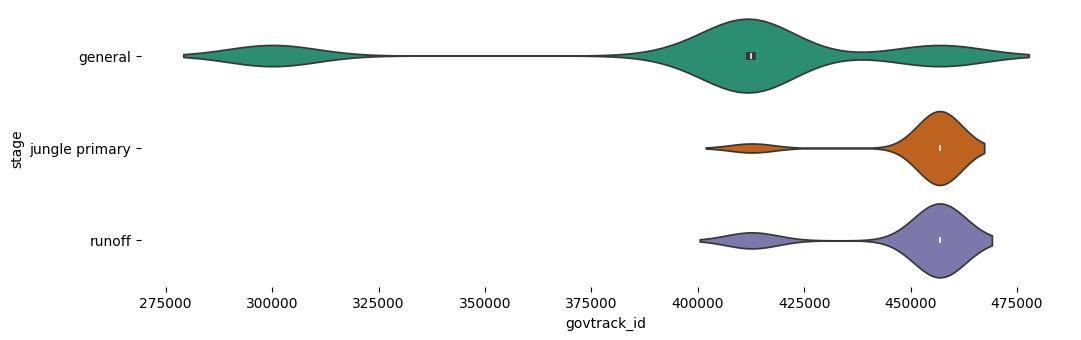

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['stage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='govtrack_id', y='stage', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

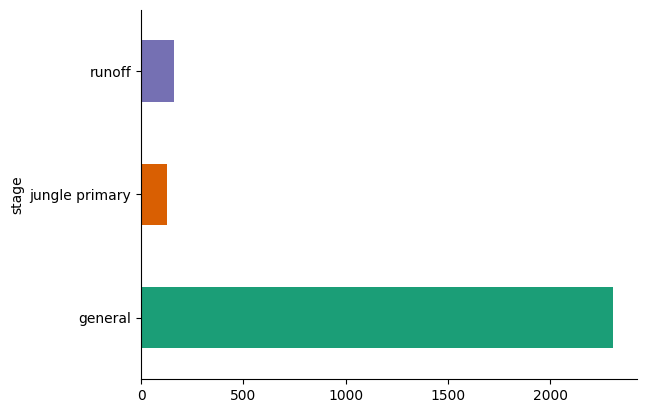

In [ ]:
# @title stage

df.groupby('stage').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

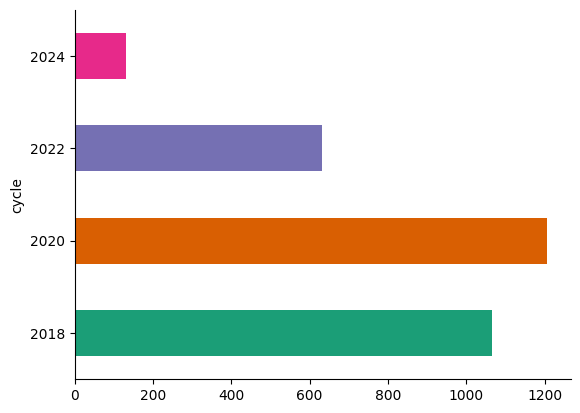

In [ ]:
# @title cycle

df.groupby('cycle').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

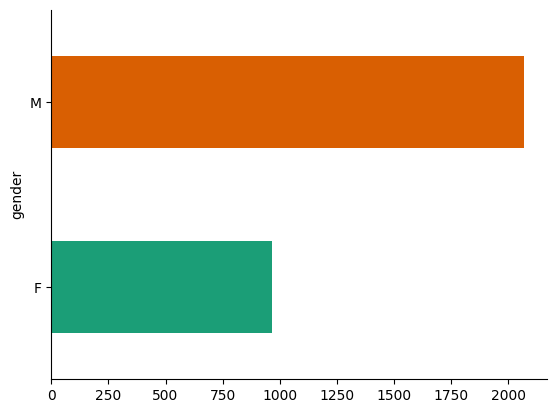

In [ ]:
# @title gender

df.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

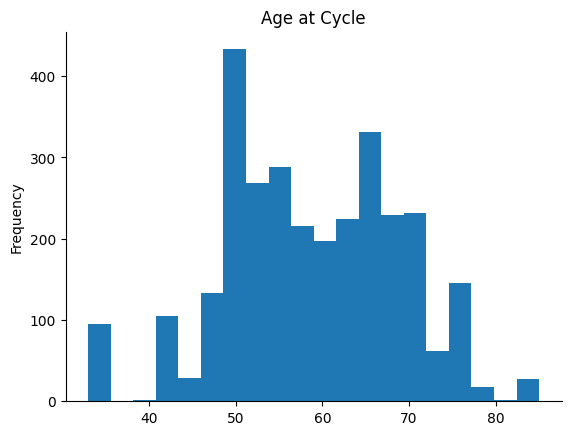

In [ ]:
df['serving_age'].plot(kind='hist', bins=20, title='Age at Cycle')
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: >

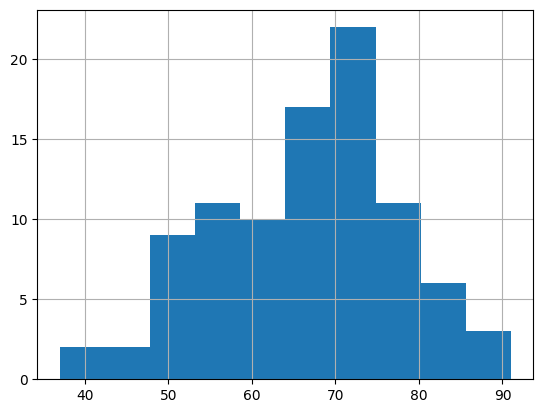

In [ ]:
df.groupby('full_name')['age'].max().hist()

### TODO:
1) add the age at the time of serving -- done ✅

2) grab more features

<Axes: >

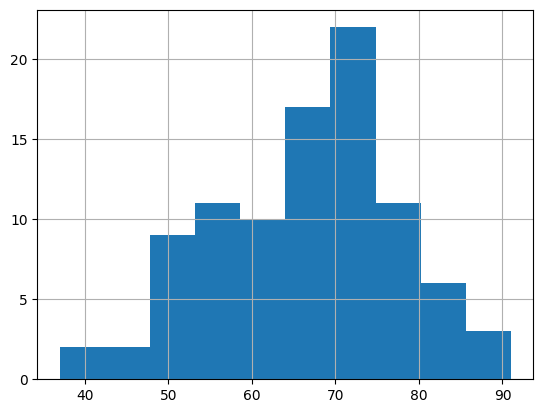

In [ ]:
df.groupby('full_name')['age'].max().hist()

In [ ]:
# todo: start_date & end_date -> How do we want to handle?

### TODO: Senator Photo Enrichment
3 - 20 Photos of senators at various events and points in time

In [ ]:
# TODO: Analysis on number and types of images available

### TODO: Emotion Detection
Classification and Valence scores

In [ ]:
# todo: update with real inferences

In [ ]:
# generating random valence values as a placeholder
#emotions = ['engagement','happiness','anticipation','excitement','confidence','pleasure','peace','disconnection','affection','esteem','sympathy']
#df['top_emotion'] = np.random.choice(emotions, size=len(df))

#df['valence'] = np.random.randint(0,10, size=len(df))

In [ ]:
df['valence_mean'].describe()

count    3035.000000
mean       26.044160
std        38.443499
min       -73.293255
25%         5.415104
50%        27.554999
75%        56.318169
max        99.428934
Name: valence_mean, dtype: float64

In [ ]:
df['race_majority'].value_counts()

race_majority
white              2695
black               218
latino hispanic     111
asian                11
Name: count, dtype: int64

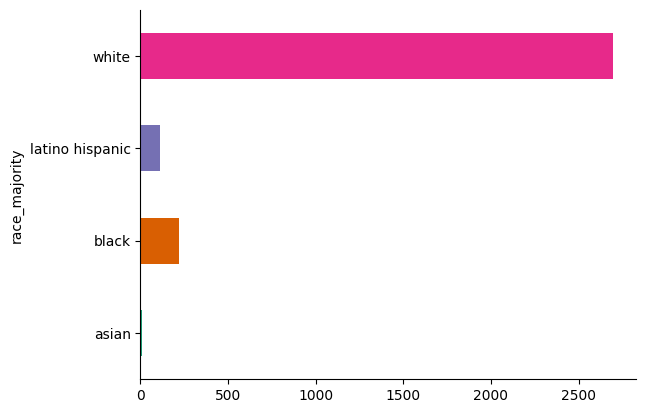

In [ ]:

df.groupby('race_majority').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df['emotion_majority'].value_counts()

emotion_majority
happy       2117
neutral      329
sad          329
angry        159
fear          90
surprise      11
Name: count, dtype: int64

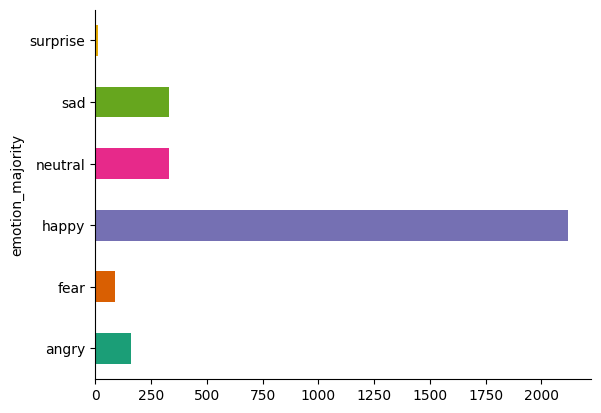

In [ ]:
df.groupby('emotion_majority').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# TODO: General EDA on the distribution of emotion inferences like frequency of emotion class and averge valence

### Final Feature Selection

In [ ]:
# create heatmap to view correlations
#sns.set(font_scale = 1)
#plt.figure(figsize = (10,10))
#sns.heatmap(df.corr(), annot=True)

In [ ]:
df['congressional'] = df['congressional'].astype(str)

In [ ]:
df.head()

full_name bioguide_id  govtrack_id   pct   birthday gender  \
0  amy_klobuchar     K000367       412242  60.0 1960-05-25      F   
1  amy_klobuchar     K000367       412242  57.0 1960-05-25      F   
2  amy_klobuchar     K000367       412242  53.0 1960-05-25      F   
3  amy_klobuchar     K000367       412242  53.6 1960-05-25      F   
4  amy_klobuchar     K000367       412242  53.0 1960-05-25      F   

  election_date     party  senate_class    stage  ...   Race   Val1   Val2  \
0    2018-11-06  Democrat           1.0  general  ...  white -0.099 -0.198   
1    2018-11-06  Democrat           1.0  general  ...  white -0.070 -0.134   
2    2018-11-06  Democrat           1.0  general  ...  white  0.396  0.297   
3    2018-11-06  Democrat           1.0  general  ...  white  0.396  0.297   
4    2018-11-06  Democrat           1.0  general  ...  white  0.396  0.297   

    Val3   Val_mean  Weight_val  Weighted_val_mean   age  serving_age  \
0 -0.297  46.458843   32.722343             -0.198  64.0           58   
1 -0.174  46.458843   32.722343             -0.126  64.0           58   
2  0.495  46.458843   32.722343              0.396  64.0           58   
3  0.495  46.458843   32.722343              0.396  64.0           58   
4  0.495  46.458843   32.722343              0.396  64.0           58   

   emotion_majority  
0             happy  
1             happy  
2             happy  
3             happy  
4             happy  

[5 rows x 33 columns]

In [ ]:
df.columns

Index(['full_name', 'bioguide_id', 'govtrack_id', 'pct', 'birthday', 'gender',
       'election_date', 'party', 'senate_class', 'stage', 'cycle',
       'start_date', 'end_date', 'congressional', 'bills-introduced',
       'bills-with-companion', 'cosponsored', 'cosponsors', 'ideology',
       'leadership', 'missed-votes', 'Emotion', 'Norm_valence', 'Race', 'Val1',
       'Val2', 'Val3', 'Val_mean', 'Weight_val', 'Weighted_val_mean', 'age',
       'serving_age', 'emotion_majority'],
      dtype='object')

In [17]:
target = ['pct'] # could we do binary classification with positive or negative score?
date_features = ['start_date','end_date','birthday'] # is cycle really "date" or categorical?

categorical_features = ['gender','party','senate_class','stage','cycle','congressional','emotion_majority', 'Race']

numerical_features = ['serving_age','Val_mean','Weighted_val_mean','bills-with-companion','cosponsored','ideology','leadership','missed-votes']


### Train/Test Split

In [18]:
df

full_name bioguide_id  govtrack_id   pct   birthday gender  \
0        amy_klobuchar     K000367       412242  60.0 1960-05-25      F   
1        amy_klobuchar     K000367       412242  57.0 1960-05-25      F   
2        amy_klobuchar     K000367       412242  53.0 1960-05-25      F   
3        amy_klobuchar     K000367       412242  53.6 1960-05-25      F   
4        amy_klobuchar     K000367       412242  53.0 1960-05-25      F   
...                ...         ...          ...   ...        ...    ...   
2589  tommy_tuberville     T000278       456796  49.7 1954-09-18      M   
2590  tommy_tuberville     T000278       456796  47.0 1954-09-18      M   
2591  tommy_tuberville     T000278       456796  50.0 1954-09-18      M   
2592  tommy_tuberville     T000278       456796  52.0 1954-09-18      M   
2593  tommy_tuberville     T000278       456796  43.9 1954-09-18      M   

     election_date       party  senate_class    stage  ...   Race   Val1  \
0       2018-11-06    Democrat           1.0  general  ...  white -0.099   
1       2018-11-06    Democrat           1.0  general  ...  white -0.070   
2       2018-11-06    Democrat           1.0  general  ...  white  0.396   
3       2018-11-06    Democrat           1.0  general  ...  white  0.396   
4       2018-11-06    Democrat           1.0  general  ...  white  0.396   
...            ...         ...           ...      ...  ...    ...    ...   
2589    2020-11-03  Republican           2.0  general  ...  white  0.123   
2590    2020-11-03  Republican           2.0  general  ...  white  0.299   
2591    2020-11-03  Republican           2.0  general  ...  white -0.098   
2592    2020-11-03  Republican           2.0  general  ...  white  0.123   
2593    2020-11-03  Republican           2.0  general  ...  white  0.053   

       Val2   Val3   Val_mean  Weight_val  Weighted_val_mean  age  \
0    -0.198 -0.297  46.458843   32.722343          -0.198000   64   
1    -0.134 -0.174  46.458843   32.722343          -0.126000   64   
2     0.297  0.495  46.458843   32.722343           0.396000   64   
3     0.297  0.495  46.458843   32.722343           0.396000   64   
4     0.297  0.495  46.458843   32.722343           0.396000   64   
...     ...    ...        ...         ...                ...  ...   
2589  0.025  0.085  12.070111   12.685963           0.077667   70   
2590  0.209  0.356  12.070111   12.685963           0.288000   70   
2591 -0.148 -0.186  12.070111   12.685963          -0.144000   70   
2592  0.025  0.085  12.070111   12.685963           0.077667   70   
2593  0.026  0.047  12.070111   12.685963           0.042000   70   

      serving_age  emotion_majority  
0              58             happy  
1              58             happy  
2              58             happy  
3              58             happy  
4              58             happy  
...           ...               ...  
2589           65           neutral  
2590           65           neutral  
2591           65           neutral  
2592           65           neutral  
2593           65           neutral  

[2594 rows x 33 columns]

In [19]:
cond = df['Emotion'].isnull()
df[cond]

Empty DataFrame
Columns: [full_name, bioguide_id, govtrack_id, pct, birthday, gender, election_date, party, senate_class, stage, cycle, start_date, end_date, congressional, bills-introduced, bills-with-companion, cosponsored, cosponsors, ideology, leadership, missed-votes, Emotion, Norm_valence, Race, Val1, Val2, Val3, Val_mean, Weight_val, Weighted_val_mean, age, serving_age, emotion_majority]
Index: []

[0 rows x 33 columns]

In [15]:
df.isnull().sum()

full_name               0
bioguide_id             0
govtrack_id             0
pct                     0
birthday                0
gender                  0
election_date           0
party                   0
senate_class            0
stage                   0
cycle                   0
start_date              0
end_date                0
congressional           0
bills-introduced        0
bills-with-companion    0
cosponsored             0
cosponsors              0
ideology                0
leadership              0
missed-votes            0
Emotion                 0
Norm_valence            0
Race                    0
Val1                    0
Val2                    0
Val3                    0
Val_mean                0
Weight_val              0
Weighted_val_mean       0
age                     0
serving_age             0
emotion_majority        0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2601 entries, 0 to 2600
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   full_name             2601 non-null   object        
 1   bioguide_id           2601 non-null   object        
 2   govtrack_id           2601 non-null   int64         
 3   pct                   2601 non-null   float64       
 4   birthday              2601 non-null   datetime64[ns]
 5   gender                2601 non-null   object        
 6   election_date         2601 non-null   object        
 7   party                 2601 non-null   object        
 8   senate_class          2601 non-null   float64       
 9   stage                 2601 non-null   object        
 10  cycle                 2601 non-null   int64         
 11  start_date            2601 non-null   datetime64[ns]
 12  end_date              2601 non-null   datetime64[ns]
 13  congressional     

In [ ]:
#df[categorical_features] = df[categorical_features].astype(str)

In [109]:
#using random shuffle
X_train, X_test, y_train, y_test = train_test_split(df[categorical_features + numerical_features],df[target], test_size=0.2, random_state=42)

In [21]:
X_train

gender        party  senate_class           stage  cycle  congressional  \
845       M   Republican           2.0         general   2020            116   
2029      M     Democrat           3.0  jungle primary   2020            117   
790       M     Democrat           1.0         general   2018            115   
1370      M   Republican           2.0         general   2020            116   
25        M     Democrat           1.0         general   2018            115   
...     ...          ...           ...             ...    ...            ...   
1638      M     Democrat           3.0         general   2022            117   
1095      F   Republican           2.0         general   2020            116   
1130      F   Republican           3.0  jungle primary   2020            116   
1294      F  Independent           1.0         general   2018            116   
860       M   Republican           2.0         general   2020            116   

     emotion_majority             Race  serving_age   Val_mean  \
845             happy            white           67 -11.454311   
2029          neutral            black           51 -11.317474   
790             happy  latino hispanic           63  10.159856   
1370            happy            white           65  12.819122   
25              happy            white           75 -28.026728   
...               ...              ...          ...        ...   
1638            angry            white           57 -28.639181   
1095            happy            white           50  44.178333   
1130            happy            white           49  21.308727   
1294            happy            white           42   0.574318   
860             happy            white           68  -4.485915   

      Weighted_val_mean  bills-with-companion  cosponsored  ideology  \
845            0.290000                  34.0        687.0  0.904129   
2029           0.396000                  18.0        369.0  0.464158   
790            0.396000                   8.0        230.0  0.322730   
1370           0.356000                  16.0        420.0  0.714706   
25            -0.184000                  19.0        470.0  0.917488   
...                 ...                   ...          ...       ...   
1638          -0.124667                  10.0        287.0  0.200704   
1095           0.388000                  15.0        362.0  0.662370   
1130           0.031333                  12.0        302.0  0.419735   
1294           0.163667                   7.0        216.0  0.232713   
860            0.290000                  34.0        687.0  0.904129   

      leadership  missed-votes  
845     0.711988        12.361  
2029    0.499642         2.529  
790     0.442863         0.668  
1370    0.519217         2.917  
25      0.692852         4.508  
...          ...           ...  
1638    0.372111         1.264  
1095    0.505583         2.222  
1130    0.450728         1.667  
1294    0.362902         0.694  
860     0.711988        12.361  

[2075 rows x 16 columns]

### Normalize Numeric Features

In [22]:
'''
# separate pipeline for numeric so more flexible with real data
num_pipe = Pipeline([
  ('min_scaler', MinMaxScaler())
])'''

In [68]:

#separate pipeline for numeric so more flexible with real data
num_pipe = Pipeline([
  ('std_scaler', StandardScaler())
])


### Feat Pipeline

In [110]:
ctprocessor = ColumnTransformer(
  transformers=[
  ('numerical', num_pipe,numerical_features ),
  ('cat', OneHotEncoder(handle_unknown="ignore", drop='if_binary'),categorical_features),
  ],
  remainder='drop'
)

In [24]:
#display
set_config(display='diagram')
display(ctprocessor)

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('min_scaler',
                                                  MinMaxScaler())]),
                                 ['serving_age', 'Val_mean',
                                  'Weighted_val_mean', 'bills-with-companion',
                                  'cosponsored', 'ideology', 'leadership',
                                  'missed-votes']),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['gender', 'party', 'senate_class', 'stage',
                                  'cycle', 'congressional', 'emotion_majority',
                                  'Race'])])

## Modeling

### Helper functions

In [25]:
## helper function for ensembling models
# evaluate a give model using cross-validation
def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=4)
    pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',model)])

    avg_mse_score = -1*np.mean(cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error'))
    avg_mae_score = -1*np.mean(cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error'))
    avg_r2_score = np.mean(cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2'))

    return {'mse':avg_mse_score,'mae':avg_mae_score,'r2':avg_r2_score}

### Supervised Modeling - Traditional Methods

In [111]:
ctprocessor.set_output(transform='default')

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['serving_age', 'Val_mean',
                                  'Weighted_val_mean', 'bills-with-companion',
                                  'cosponsored', 'ideology', 'leadership',
                                  'missed-votes']),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['gender', 'party', 'senate_class', 'stage',
                                  'cycle', 'congressional', 'emotion_majority',
                                  'Race'])])

#### Linear Regression
Numeric features are standardized using StandardScaler and Categorical features One Hot Encoding

In [27]:
lr = LinearRegression()

In [112]:
lr_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',lr)])
lr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['serving_age', 'Val_mean',
                                                   'Weighted_val_mean',
                                                   'bills-with-companion',
                                                   'cosponsored', 'ideology',
                                                   'leadership',
                                                   'missed-votes']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'party',
                                                   'senate_class', 'stage',
                                                   'cycle', 'congressional',
                                                   'emotion_majority',
                                                   'Race'])])),
                ('model', LinearRegression())])

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [29]:
lr_train_scores = evaluate_model(lr,X_train,y_train)
lr_train_scores

{'mse': 26.769606333256828,
 'mae': 3.7854037137606618,
 'r2': 0.4593045088080354}

##### Testing Scores

In [30]:
lr_scores = evaluate_model(lr,X_test,y_test)
lr_scores

{'mse': 26.815346077074373,
 'mae': 3.7904369211528413,
 'r2': 0.5482710432259925}

#### Decision Tree

NOTE: SKLearn's Decision Tree Algorithm DOES NOT allow direct use of cateogrical features. Not clear if there is a Python package that supports this. LabelEncoding only works if there is a nominal relationship in the features.

AKA don't need encoded categorical features

In [31]:
# https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/
dtr_parameters = {'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

In [32]:
dtr = DecisionTreeRegressor(random_state=0)

In [33]:
dtr_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',GridSearchCV(dtr, dtr_parameters, n_jobs=2))])
dtr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('min_scaler',
                                                                   MinMaxScaler())]),
                                                  ['serving_age', 'Val_mean',
                                                   'Weighted_val_mean',
                                                   'bills-with-companion',
                                                   'cosponsored', 'ideology',
                                                   'leadership',
                                                   'missed-votes']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'party',
                                                   'senate_class', 'stage',
                                                   'cycle', 'congressional',
                                                   'emotion_majority',
                                                   'Race'])])),
                ('model',
                 GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
                              n_jobs=2,
                              param_grid={'max_depth': [None, 5, 10],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [2, 5, 10]}))])

In [34]:
dtr_pipeline[1].best_params_

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}

In [35]:
dtr = dtr_pipeline[1].best_estimator_

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [36]:
dtr_train_scores = evaluate_model(dtr,X_train,y_train)
dtr_train_scores

{'mse': 22.140335262354732, 'mae': 3.375697663920058, 'r2': 0.551448354782363}

##### Testing Scores

In [37]:
dtr_scores = evaluate_model(dtr,X_test,y_test)
dtr_scores

{'mse': 25.40679157968559, 'mae': 3.6039739399407305, 'r2': 0.5874654408522371}

Feature importance based on mean decrease in impurity

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

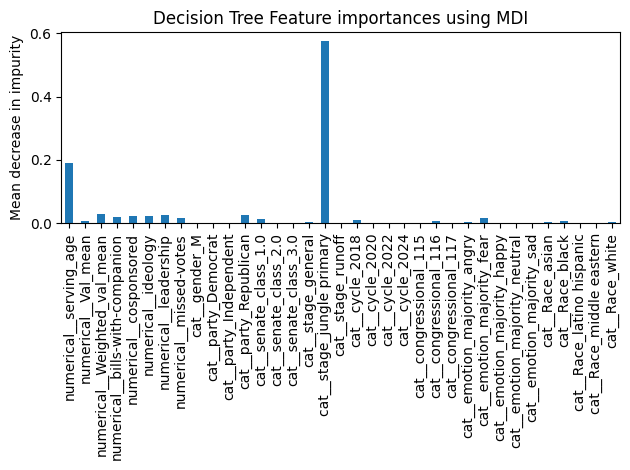

In [38]:
feature_names = dtr_pipeline[:-1].get_feature_names_out()
forest_importances = pd.Series(dtr.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Decision Tree Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Other Methods
K Nearest Neighbors Regressor

Requires Encoding

In [39]:
# https://medium.com/@agrawalsam1997/hyperparameter-tuning-of-knn-classifier-a32f31af25c7
knr_parameters = parameter={'n_neighbors': np.arange(2, 30, 1)}

In [40]:
knr = KNeighborsRegressor(n_neighbors=2)

In [41]:
knr_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',GridSearchCV(knr, knr_parameters, n_jobs=2))])
knr_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('min_scaler',
                                                                   MinMaxScaler())]),
                                                  ['serving_age', 'Val_mean',
                                                   'Weighted_val_mean',
                                                   'bills-with-companion',
                                                   'cosponsored', 'ideology',
                                                   'leadership',
                                                   'missed-votes']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'party',
                                                   'senate_class', 'stage',
                                                   'cycle', 'congressional',
                                                   'emotion_majority',
                                                   'Race'])])),
                ('model',
                 GridSearchCV(estimator=KNeighborsRegressor(n_neighbors=2),
                              n_jobs=2,
                              param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}))])

In [42]:
knr_pipeline[1].best_params_

{'n_neighbors': 5}

In [43]:
knr = knr_pipeline[1].best_estimator_

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [44]:
knr_train_scores = evaluate_model(knr,X_train,y_train)
knr_train_scores

{'mse': 24.296945907696717, 'mae': 3.51550585288013, 'r2': 0.5104189097306251}

##### Testing Scores

In [45]:
knr_scores = evaluate_model(knr,X_test,y_test)
knr_scores

{'mse': 28.784458228085867, 'mae': 3.912172063208109, 'r2': 0.5299652180358302}

### Supervised Methods - Ensemble Learning

#### Random Forest

In [46]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
rf_parameters = {
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 10, 15],
    'n_estimators': [100, 250, 500]
}

In [47]:
rf = RandomForestRegressor(random_state=42)

In [48]:
rf_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',GridSearchCV(rf, rf_parameters, n_jobs=2))])
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('min_scaler',
                                                                   MinMaxScaler())]),
                                                  ['serving_age', 'Val_mean',
                                                   'Weighted_val_mean',
                                                   'bills-with-companion',
                                                   'cosponsored', 'ideology',
                                                   'leadership',
                                                   'missed-votes']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'party',
                                                   'senate_class', 'stage',
                                                   'cycle', 'congressional',
                                                   'emotion_majority',
                                                   'Race'])])),
                ('model',
                 GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              n_jobs=2,
                              param_grid={'min_samples_leaf': [1, 3, 5],
                                          'min_samples_split': [2, 10, 15],
                                          'n_estimators': [100, 250, 500]}))])

In [49]:
rf_pipeline[1].best_params_

{'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 500}

In [50]:
rf = rf_pipeline[1].best_estimator_

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [51]:
rf_train_scores = evaluate_model(rf,X_train,y_train)
rf_train_scores

{'mse': 19.153771510064214, 'mae': 3.118058105598682, 'r2': 0.61290592470073}

##### Testing Scores

In [52]:
rf_scores = evaluate_model(rf,X_test,y_test)
rf_scores

{'mse': 21.659389249178304, 'mae': 3.3549294799919718, 'r2': 0.638534346600536}

Feature importance based on mean decrease in impurity

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

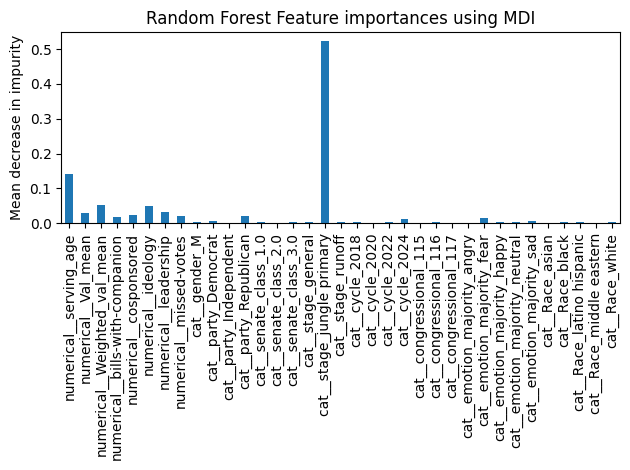

In [108]:
feature_names = rf_pipeline[:-1].get_feature_names_out()
forest_importances = pd.Series(rf.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Random Forest Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### XGBoost

In [ ]:
X_train_xgb = X_train.copy()
X_train_xgb[categorical_features] = X_train[categorical_features].astype("category")
X_test_xgb = X_test.copy()
X_test_xgb[categorical_features] = X_test[categorical_features].astype("category")

In [ ]:
# https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d
xgbr_parameters = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.3, 0.6],
    'subsample': [0.5, 1],
    'n_estimators': [50, 100, 200]
}

In [ ]:
xgbr = xgb.XGBRegressor(tree_method="hist", enable_categorical=True)

In [ ]:
xgbr_pipeline = GridSearchCV(xgbr, xgbr_parameters, n_jobs=2)
xgbr_pipeline.fit(X_train_xgb,y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': [0.1, 0.3, 0.6],
                         'max_depth': [3, 6, 9], 'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 1]})

In [ ]:
xgbr_pipeline.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}

In [ ]:
xgbr = xgbr_pipeline.best_estimator_

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [ ]:
xgbr_train_scores = evaluate_model(xgbr,X_train_xgb,y_train)
xgbr_train_scores

{'mse': 18.765550135868185,
 'mae': 3.1895526679283983,
 'r2': 0.5575463635690328}

##### Testing Scores

In [ ]:
xgbr_scores = evaluate_model(xgbr,X_test_xgb,y_test)
xgbr_scores

{'mse': 23.64677484304256, 'mae': 3.460368065717123, 'r2': 0.4396298673168261}

Feature importance based on mean decrease in impurity

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

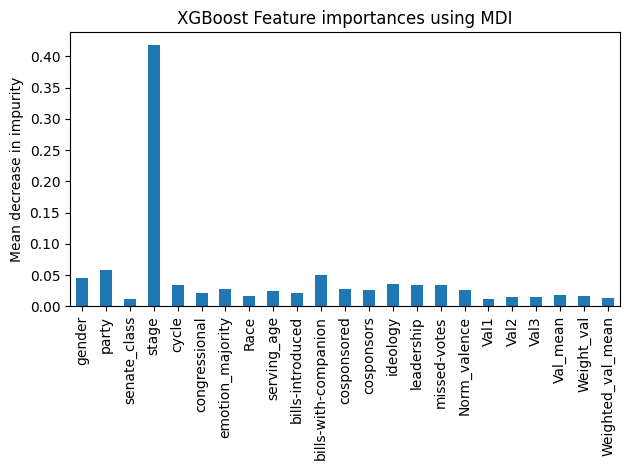

In [ ]:
forest_importances = pd.Series(xgbr.feature_importances_, index=xgbr.feature_names_in_)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("XGBoost Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### XGBoost WITH OHE and Scaling

In [ ]:
# https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d
xgbr_preproc_parameters = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.3, 0.6],
    'subsample': [0.5, 1],
    'n_estimators': [50, 100, 200]
}

In [ ]:
xgbr_preproc = xgb.XGBRegressor(tree_method="hist")

In [ ]:
xgbr_preproc_pipeline = Pipeline(steps=[('preprocessor', ctprocessor), ('model',GridSearchCV(xgbr_preproc, xgbr_preproc_parameters, n_jobs=2))])
xgbr_preproc_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('min_scaler',
                                                                   MinMaxScaler())]),
                                                  ['serving_age',
                                                   'bills-introduced',
                                                   'bills-with-companion',
                                                   'cosponsored', 'cosponsors',
                                                   'ideology', 'leadership',
                                                   'missed-votes',
                                                   'Norm_valence', 'Val1',
                                                   'Val2', 'Val3', 'Val_mean',
                                                   'Weight_val',
                                                   'Weighted_val_mean']),
                                                 ('cat',
                                                  OneHotEncoder...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...),
                              n_jobs=2,
                              param_grid={'learning_rate': [0.1, 0.3, 0.6],
                                          'max_depth': [3, 6, 9],
                                          'n_estimators': [50, 100, 200],
                                          'subsample': [0.5, 1]}))])

In [ ]:
xgbr_preproc_pipeline[1].best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}

In [ ]:
xgbr_preproc = xgbr_preproc_pipeline[1].best_estimator_

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [ ]:
xgbr_preproc_train_scores = evaluate_model(xgbr_preproc,X_train,y_train)
xgbr_preproc_train_scores

{'mse': 18.765550135868185,
 'mae': 3.1895526679283983,
 'r2': 0.5575463635690328}

##### Testing Scores

In [ ]:
xgbr_preproc_scores = evaluate_model(xgbr_preproc,X_test,y_test)
xgbr_preproc_scores

{'mse': 23.64677484304256, 'mae': 3.460368065717123, 'r2': 0.4396298673168261}

Feature importance based on mean decrease in impurity

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

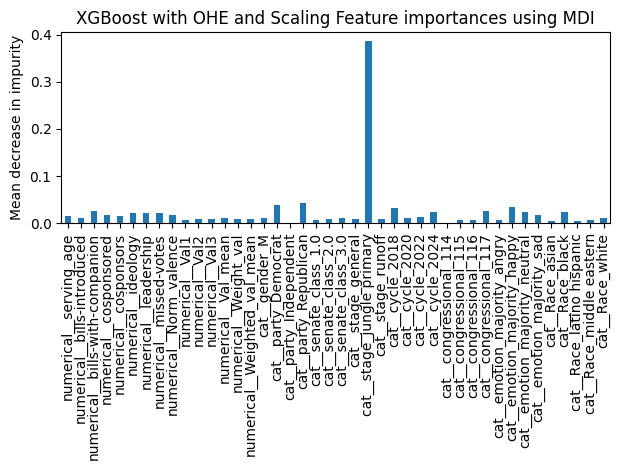

In [ ]:
feature_names = xgbr_preproc_pipeline[:-1].get_feature_names_out()
forest_importances = pd.Series(xgbr_preproc.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("XGBoost with OHE and Scaling Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### CatBoost
No Feature Processing Needed

https://catboost.ai/en/docs/features/categorical-features

In [54]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.0 MB/s eta 0:00:00


In [55]:
from catboost import CatBoostRegressor, Pool

In [56]:
# https://www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-regression
cbr_parameters = {
    'iterations': [100, 250, 500],
    'learning_rate': [0.1, 0.4, 0.6],
    'depth':[1, 3, 6],
}

In [57]:
X_train[categorical_features] = X_train[categorical_features].astype('string')
X_test[categorical_features] = X_test[categorical_features].astype('string')

X_train[categorical_features].dtypes

gender              string[python]
party               string[python]
senate_class        string[python]
stage               string[python]
cycle               string[python]
congressional       string[python]
emotion_majority    string[python]
Race                string[python]
dtype: object

In [58]:
pool_train = Pool(X_train, y_train, cat_features = categorical_features)
pool_test = Pool(X_test, cat_features = categorical_features)

In [59]:
# https://towardsdatascience.com/how-do-you-use-categorical-features-directly-with-catboost-947b211c2923
cbr = CatBoostRegressor(loss_function='RMSE', task_type='CPU',random_state=1,verbose=False)
grid_search_result = cbr.grid_search(cbr_parameters, pool_train,verbose=False)


bestTest = 5.388640032
bestIteration = 99


bestTest = 5.106716635
bestIteration = 74


bestTest = 5.083119812
bestIteration = 65


bestTest = 5.177773994
bestIteration = 248


bestTest = 5.025170631
bestIteration = 218


bestTest = 4.912426502
bestIteration = 249


bestTest = 5.132379849
bestIteration = 493


bestTest = 4.923005802
bestIteration = 490


bestTest = 4.789052679
bestIteration = 488


bestTest = 4.954710687
bestIteration = 99


bestTest = 4.596831801
bestIteration = 95


bestTest = 4.626837544
bestIteration = 99


bestTest = 4.668978091
bestIteration = 245


bestTest = 4.402300029
bestIteration = 183


bestTest = 4.462226677
bestIteration = 133


bestTest = 4.493412312
bestIteration = 488


bestTest = 4.401940591
bestIteration = 290


bestTest = 4.462226677
bestIteration = 133


bestTest = 4.618241853
bestIteration = 98


bestTest = 4.392180584
bestIteration = 82


bestTest = 4.44972479
bestIteration = 47


bestTest = 4.457642965
bestIteration = 247


bestTest = 4.424140

In [60]:
grid_search_result['params']

{'depth': 6, 'learning_rate': 0.4, 'iterations': 100}

In [61]:
cbr.get_params()

{'loss_function': 'RMSE',
 'verbose': False,
 'task_type': 'CPU',
 'random_state': 1,
 'depth': 6,
 'learning_rate': 0.4,
 'iterations': 100}

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [62]:
train_predictions = cbr.predict(pool_train)

In [63]:
cbr_train_mse = mean_squared_error(y_train, train_predictions)
cbr_train_mae = mean_absolute_error(y_train, train_predictions)
cbr_train_r2 = r2_score(y_train, train_predictions)

In [64]:
cbr_train_scores = {'mse':cbr_train_mse,'mae':cbr_train_mae,'r2':cbr_train_r2}
cbr_train_scores

{'mse': 13.621605629120694, 'mae': 2.6986776353857342, 'r2': 0.727531027090351}

##### Testing Scores

In [65]:
test_predictions = cbr.predict(pool_test)

In [66]:
cbr_mse = mean_squared_error(y_test, test_predictions)
cbr_mae = mean_absolute_error(y_test, test_predictions)
cbr_r2 = r2_score(y_test, test_predictions)

In [67]:
cbr_scores = {'mse':cbr_mse,'mae':cbr_mae,'r2':cbr_r2}
cbr_scores

{'mse': 18.0368778080969, 'mae': 3.11721149613168, 'r2': 0.7356688766123192}

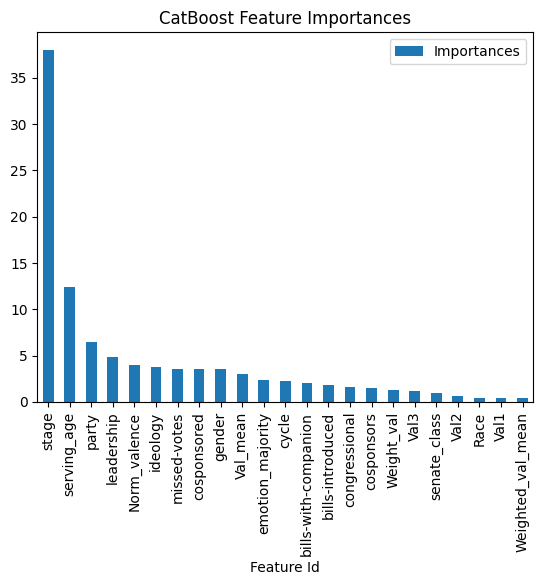

In [ ]:
cbr.get_feature_importance(prettified=True).plot.bar(x='Feature Id', y='Importances')
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importances")
fig.tight_layout()

#### CatBoost WITH OneHotEncoding and StdScaler Transformed Data

https://catboost.ai/en/docs/features/categorical-features

In [127]:
ctprocessor.fit(X_train)

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['serving_age', 'Val_mean',
                                  'Weighted_val_mean', 'bills-with-companion',
                                  'cosponsored', 'ideology', 'leadership',
                                  'missed-votes']),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['gender', 'party', 'senate_class', 'stage',
                                  'cycle', 'congressional', 'emotion_majority',
                                  'Race'])])

In [128]:
X_train_t = ctprocessor.transform(X_train)
X_test_t = ctprocessor.transform(X_test)

In [129]:
features = ctprocessor.get_feature_names_out()
X_train_t = pd.DataFrame(X_train_t, columns=features)
X_test_t = pd.DataFrame(X_test_t, columns=features)

In [130]:
# https://towardsdatascience.com/how-do-you-use-categorical-features-directly-with-catboost-947b211c2923
cbr_t = CatBoostRegressor(n_estimators=200,loss_function='RMSE',learning_rate=0.4,depth=3, task_type='CPU',random_state=1,verbose=False)

In [131]:
pool_train_t = Pool(X_train_t, y_train)
pool_test_t = Pool(X_test_t)

In [132]:
cbr_t.fit(pool_train_t)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [133]:
train_predictions_t = cbr_t.predict(pool_train_t)

In [134]:
cbr_train_mse_t = mean_squared_error(y_train, train_predictions_t)
cbr_train_mae_t = mean_absolute_error(y_train, train_predictions_t)
cbr_train_r2_t = r2_score(y_train, train_predictions_t)

In [135]:
cbr_train_scores_t = {'mse':cbr_train_mse_t,'mae':cbr_train_mae_t,'r2':cbr_train_r2_t}
cbr_train_scores_t

{'mse': 12.605251744277895, 'mae': 2.5866631251300376, 'r2': 0.747860855060398}

##### Testing Scores

In [136]:
test_predictions_t = cbr_t.predict(pool_test_t)

In [137]:
cbr_mse_t = mean_squared_error(y_test, test_predictions_t)
cbr_mae_t = mean_absolute_error(y_test, test_predictions_t)
cbr_r2_t = r2_score(y_test, test_predictions_t)

In [138]:
cbr_scores_t = {'mse':cbr_mse_t,'mae':cbr_mae_t,'r2':cbr_r2_t}
cbr_scores_t

{'mse': 17.826162338669533,
 'mae': 3.0849430399372935,
 'r2': 0.7387569197504666}

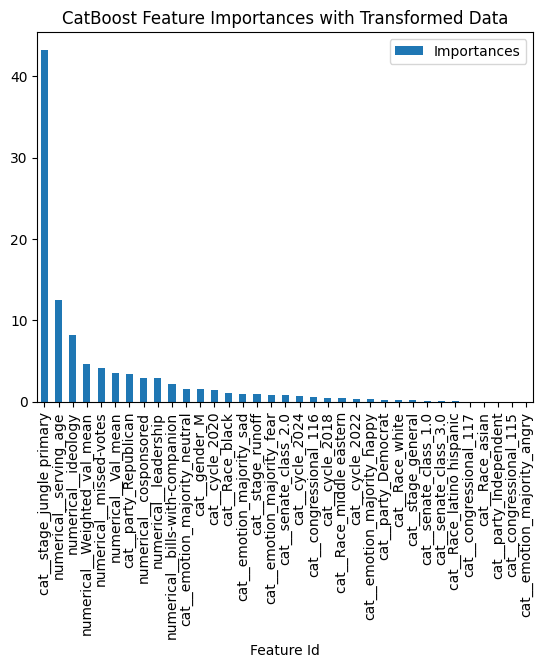

In [139]:
cbr_t.get_feature_importance(prettified=True).plot.bar(x='Feature Id', y='Importances')
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importances with Transformed Data")
fig.tight_layout()

In [ ]:
# TODO: Properly Extract Feature Names

USING SHAP with CatBoost

In [83]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.2 MB/s eta 0:00:00


In [125]:
import shap

shap.initjs()

In [140]:
cbr_t

In [156]:
# compute explainer
explainer = shap.TreeExplainer(cbr_t)

In [157]:
shap_values = explainer(X_test_t)

In [158]:
shap.initjs()

# visualize the test set prediction's explanation
shap.plots.force(shap_values)

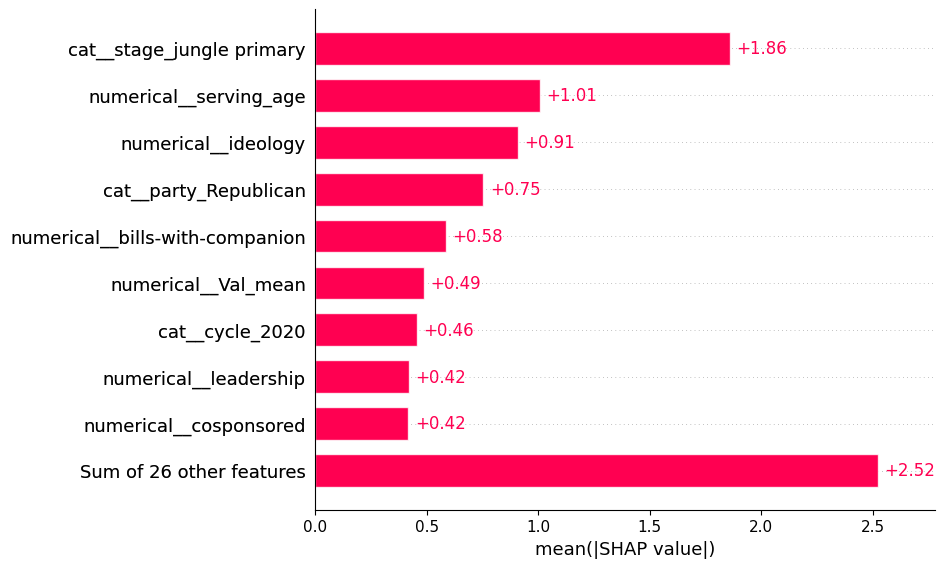

In [159]:
'''Here the features are ordered from the highest to the lowest effect on the prediction. It takes in account the absolute SHAP value, so it does not matter if the feature affects the prediction in a positive or negative way.

Summary plot: beeswarm
'''
shap.plots.bar(shap_values)

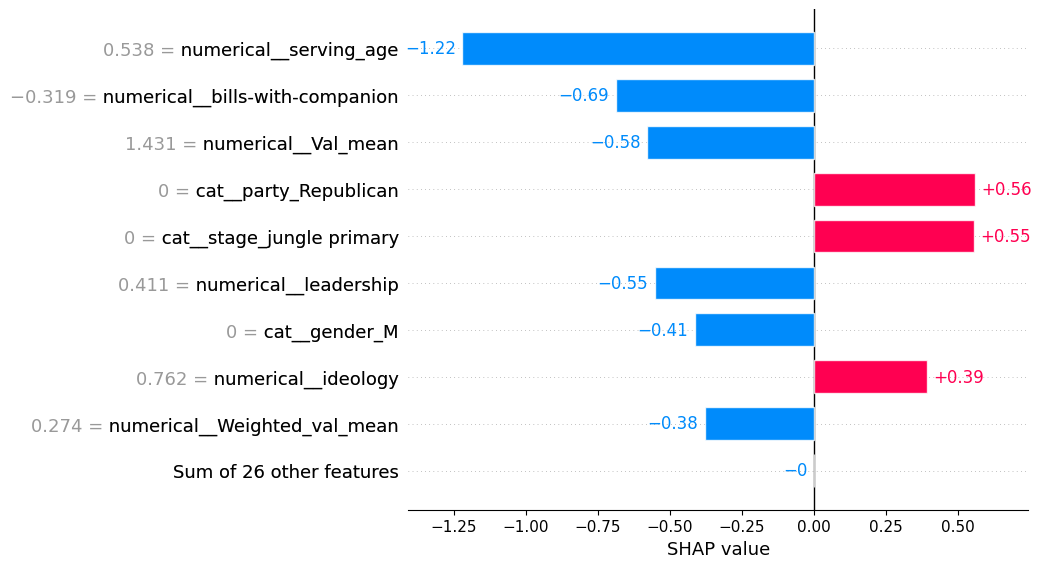

In [160]:
'''This plot shows us what are the main features affecting the prediction of a single observation, and the magnitude of the SHAP value for each feature.'''
shap.plots.bar(shap_values[0])

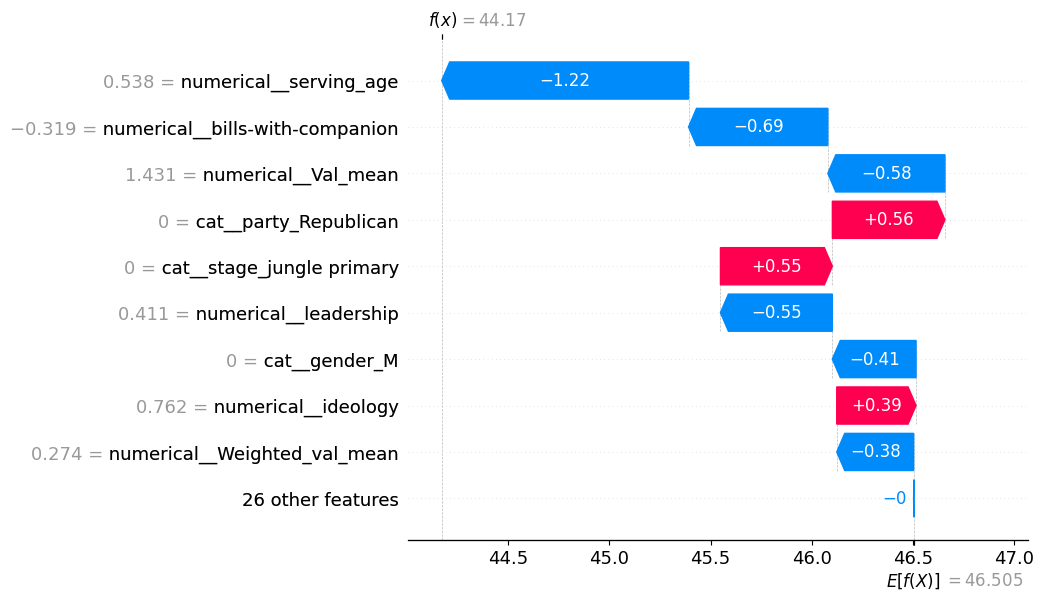

In [161]:
shap.plots.waterfall(shap_values[0])

In [163]:
'''The force plot is another way to see the effect each feature has on the prediction, for a given observation. In this plot the positive SHAP values
are displayed on the left side and the negative on the right side, as if competing against each other.
The highlighted value is the prediction for that observation.'''
shap.initjs()

shap.plots.force(shap_values[0])

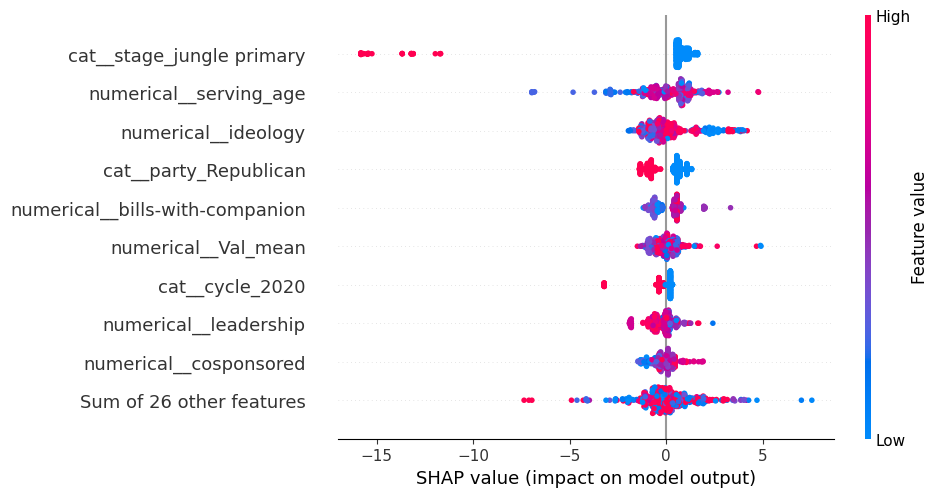

In [149]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [154]:
y_test

pct
211   44.0
2121  47.0
1738  58.0
2292  47.0
1669  52.0
...    ...
944   47.3
49    45.5
700   51.0
1114  22.0
48    50.0

[519 rows x 1 columns]

In [152]:
explainer = shap.TreeExplainer(cbr_t)
shap_values = explainer(X_test_t, y_test)

In [155]:
shap.plots.beeswarm(shap_values[..., 47.3])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### CatBoost Witholding Emotion Features
No Feature Processing Needed

https://catboost.ai/en/docs/features/categorical-features

In [ ]:
# https://towardsdatascience.com/how-do-you-use-categorical-features-directly-with-catboost-947b211c2923
cbr_ne = CatBoostRegressor(n_estimators=200,loss_function='RMSE',learning_rate=0.4,depth=3, task_type='CPU',random_state=1,verbose=False)

In [ ]:
categorical_features_ne = ['gender', 'party', 'senate_class', 'stage', 'cycle', 'race_majority']

In [ ]:
pool_train_ne = Pool(X_train.drop(columns=['emotion_majority','valence_mean']), y_train, cat_features = categorical_features_ne)
pool_test_ne = Pool(X_test.drop(columns=['emotion_majority','valence_mean']), cat_features = categorical_features_ne)

In [ ]:
cbr_ne.fit(pool_train_ne)

##### Training Scores
Refer to this for evaluation of train/test scores: https://datascience.stackexchange.com/questions/70054/interpretation-for-test-score-training-score-and-validation-score-in-machine-l

In [ ]:
train_predictions_ne = cbr_ne.predict(pool_train_ne)

In [ ]:
cbr_train_mse_ne = mean_squared_error(y_train, train_predictions_ne)
cbr_train_mae_ne = mean_absolute_error(y_train, train_predictions_ne)
cbr_train_r2_ne = r2_score(y_train, train_predictions_ne)

In [ ]:
cbr_train_scores_ne = {'mse':cbr_train_mse_ne,'mae':cbr_train_mae_ne,'r2':cbr_train_r2_ne}
cbr_train_scores_ne

{'mse': 18.759931719396654,
 'mae': 3.2107907931881097,
 'r2': 0.6764219834616245}

##### Testing Scores

In [ ]:
test_predictions_ne = cbr_ne.predict(pool_test_ne)

In [ ]:
cbr_mse_ne = mean_squared_error(y_test, test_predictions_ne)
cbr_mae_ne = mean_absolute_error(y_test, test_predictions_ne)
cbr_r2_ne = r2_score(y_test, test_predictions_ne)

In [ ]:
cbr_scores_ne = {'mse':cbr_mse_ne,'mae':cbr_mae_ne,'r2':cbr_r2_ne}
cbr_scores_ne

{'mse': 17.779589875852157, 'mae': 3.102275781013338, 'r2': 0.657956092256357}

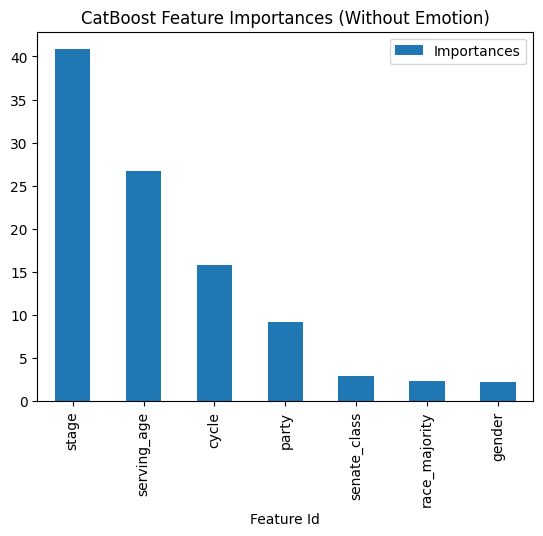

In [ ]:
cbr_ne.get_feature_importance(prettified=True).plot.bar(x='Feature Id', y='Importances')
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importances (Without Emotion)")
fig.tight_layout()

## Modeling Evaulation

In [ ]:
# TODO: Jungle Primary feature importance potentially very interesting - https://politicaldictionary.com/words/jungle-primary/

## Unsupervised Modeling - TODO Week 10!

### KMeans and Hierarchical Clustering

In [ ]:
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
kmeans.labels_
kmeans.predict([[0, 0], [12, 3]])
kmeans.cluster_centers_

array([[10.,  2.],
       [ 1.,  2.]])

In [ ]:
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X)
clustering.labels_

array([1, 1, 1, 0, 0, 0])